<a href="https://colab.research.google.com/github/JueunL/IANNWTF-Group25/blob/main/HW_25_05_Vera.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0 

170500096/170498071 [==============================] - 2s 0us/step


In [ ]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [ ]:
train_labels = train_labels.reshape(-1,)
print(train_labels[:10])

[6 9 9 4 1 1 2 7 8 3]


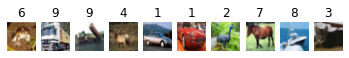

In [ ]:
fig, ax = plt.subplots(1,10)
for i in range(10):
  img = train_images[i]
  lbl = train_labels[i]

  ax[i].imshow(img)
  ax[i].set_title(lbl)
  ax[i].axis("off")

In [ ]:
train_dataset_images = tf.data.Dataset.from_tensor_slices(train_images)
train_dataset_images = train_dataset_images.map(lambda img : tf.cast(img, tf.float32))

train_dataset_targets = tf.data.Dataset.from_tensor_slices(train_labels)
train_dataset_targets = train_dataset_targets.map(lambda t : tf.one_hot(t, 10, axis=0))
print(train_dataset_images)

train_dataset = tf.data.Dataset.zip((train_dataset_images, train_dataset_targets))
train_dataset = train_dataset.batch(64)
train_dataset = train_dataset.shuffle(buffer_size=64)
print(train_dataset)

test_dataset_images = tf.data.Dataset.from_tensor_slices(test_images)
test_dataset_images = train_dataset_images.map(lambda img : tf.cast(img, tf.float32))
print(test_dataset_images)

test_dataset_targets = tf.data.Dataset.from_tensor_slices(test_labels)
test_dataset_targets = test_dataset_targets.map(lambda t : tf.one_hot(t, 10, axis=0))

test_dataset = tf.data.Dataset.zip((train_dataset_images, train_dataset_targets))
test_dataset = train_dataset.batch(64)
test_dataset = train_dataset.shuffle(buffer_size=64)
print(test_dataset)

<MapDataset shapes: (32, 32, 3), types: tf.float32>
<ShuffleDataset shapes: ((None, 32, 32, 3), (None, 10)), types: (tf.float32, tf.float32)>
<MapDataset shapes: (32, 32, 3), types: tf.float32>
<ShuffleDataset shapes: ((None, 32, 32, 3), (None, 10)), types: (tf.float32, tf.float32)>


In [ ]:
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer

class Model(Model):

  def __init__(self):
    super(Model, self).__init__()
    self.layers_list = [
                        layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same', 
                                      kernel_regularizer=tf.keras.regularizers.l2, input_shape=(32,32,3)
                                      ),
                        layers.BatchNormalization(),
                        layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same', 
                                      kernel_regularizer=tf.keras.regularizers.l2
                                      ),
                        layers.BatchNormalization(),
                        layers.MaxPooling2D(pool_size=(2,2)),
                        layers.Dropout(0.20),

                        layers.Conv2D(128, kernel_size=(3,3), activation='relu', padding='same', 
                                      kernel_regularizer=tf.keras.regularizers.l2
                                      ),
                        layers.BatchNormalization(),
                        layers.Conv2D(128, kernel_size=(3,3), activation='relu', padding='same', 
                                      kernel_regularizer=tf.keras.regularizers.l2
                                      ),
                        layers.BatchNormalization(),
                        layers.MaxPooling2D(pool_size=(2,2)),
                        layers.Dropout(0.30),

                        layers.Conv2D(256, kernel_size=(3,3), activation='relu', padding='same', 
                                      kernel_regularizer=tf.keras.regularizers.l2
                                      ),
                        layers.BatchNormalization(),
                        layers.Conv2D(256, kernel_size=(3,3), activation='relu', padding='same', 
                                      kernel_regularizer=tf.keras.regularizers.l2
                                      ),
                        layers.BatchNormalization(),
                        layers.MaxPooling2D(pool_size=(2,2)),
                        layers.Dropout(0.40),

                        layers.Flatten(),

                        layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2),
                        layers.Dropout(0.30),

                        layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2),
                        layers.Dropout(0.20),

                        layers.Dense(10, activation='softmax')
                        ]

  def call(self, x, training = True):
    for layer in self.layers_list:
      x = layer(x, training=training)
    return x  

In [ ]:
def train_step(model, input, target, loss_function, optimizer):
  with tf.GradientTape() as tape:
    prediction = model(input, training=True)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))  
  return loss

def test(model, test_data, loss_function):
  test_accuracy_aggregator = []
  test_loss_aggregator = [] 

  for (input, target) in test_data:
    prediction = model(input, training=False)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy 

In [ ]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 30
learning_rate = 0.001
running_average_factor = 0.95

# Initialize the model.
model = Model()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    train_dataset = train_dataset.shuffle(buffer_size=128)
    test_dataset = test_dataset.shuffle(buffer_size=128)

    #training (and checking in with training)
    running_average = 0
    for (input,target) in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    #testing
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: __ 0
Epoch: __ 1
Epoch: __ 2
Epoch: __ 3
Epoch: __ 4
Epoch: __ 5
Epoch: __ 6
Epoch: __ 7
Epoch: __ 8
Epoch: __ 9
Epoch: __ 10
Epoch: __ 11
Epoch: __ 12
Epoch: __ 13
Epoch: __ 14
Epoch: __ 15
Epoch: __ 16
Epoch: __ 17
Epoch: __ 18
Epoch: __ 19
Epoch: __ 20
Epoch: __ 21
Epoch: __ 22
Epoch: __ 23
Epoch: __ 24
Epoch: __ 25
Epoch: __ 26
Epoch: __ 27
Epoch: __ 28
Epoch: __ 29


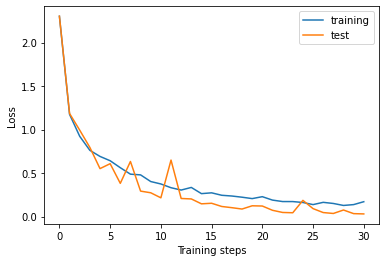

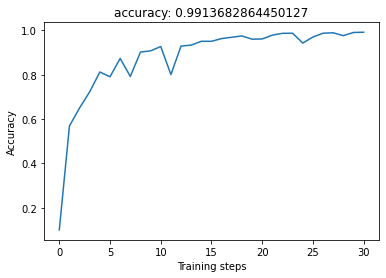

In [ ]:
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

plt.figure()
line1, = plt.plot(test_accuracies)
plt.title('accuracy: '+ str(np.max(test_accuracies)))
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()